# Optimization

##### Author: Mojtaba Amini 

##### HW1
##### Deadline: 04/11/2022

In the first part, the random data has been generated.

Original size of X= 300	Unlabeled size = 294	labeled size = 6
Original size of y= 300	Unlabeled size = 294	labeled size = 6


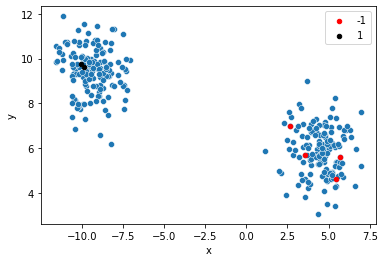

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_blobs(n_samples=300, centers=2, n_features=2)
x_Unlabeled ,x_labeled_bar,y1,y_label = train_test_split(X,y,test_size=0.02)
print(f"Original size of X= {X.shape[0]}\tUnlabeled size = {x_Unlabeled.shape[0]}\tlabeled size = {x_labeled_bar.shape[0]}")
print(f"Original size of y= {y.shape[0]}\tUnlabeled size = {y1.shape[0]}\tlabeled size = {y_label.shape[0]}")

y_label=y_label*2-1
df = DataFrame(dict(x=x_labeled_bar[:,0], y=x_labeled_bar[:,1], label=y_label))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
sns.scatterplot(ax=ax,x=X[:,0],y=X[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()


### <mark><b>Similarity Measure function</b></mark>

<ol>
  <li><b>Euclidean Distance</b></li>
  At first, for similarity, the similarity measure function has been defined as below:
  $$ d(x,y) = {e^{\sum_{i=1}^k (x_i-y_i)^2 }}$$

  So the similarity matrix is defined as below:

  $$\omega_{ij}={e^{(x_{1i}-x_{1j})^2+(x_{2i}-x_{2j})^2}}$$

  ${x_1}$ refer to the first dimension and ${x_2}$ is the second dimension in 2D.

  ${i ,j}$ are two indexes for labeled and unlabeled data. 

  Therefore the matrix is as below:

  $$
\omega_{ij}= \begin{bmatrix}
{e^{(x_{11}-x_{11})^2+(x_{21}-x_{21})^2}} & {e^{(x_{11}-x_{12})^2+(x_{21}-x_{22})^2}} & \cdots \\
{e^{(x_{12}-x_{11})^2+(x_{22}-x_{21})^2}} & \ddots & \cdots \\
\vdots & \cdots & \cdots \\
\end{bmatrix}
$$
</ol>

<b>Defining Similarity functions:</b>

In [12]:
def euclidean_distance(x,y):
  
  return np.exp(-np.linalg.norm(x-y)**2)


<b> Initializing matrixes</b>

In [13]:
def initialize_parameters(x_Unlabeled):
  np.random.seed(4)
# initialize the parameters with non-zeros numbers between(0,1)
  y_unlabel=np.random.rand(len(x_Unlabeled))*0.01
  return y_unlabel

<b>Defining the similarity matrix</b>

In [14]:
def similarity(x_Unlabeled,x_labeled_bar,type):
  wij=np.zeros((len(x_labeled_bar),len(x_Unlabeled)))
  wij_bar=np.zeros((len(x_Unlabeled),len(x_Unlabeled)))
  if type=="Euclidean" :
    for j in range(len(x_Unlabeled)):
      for i in range(len(x_labeled_bar)):
        wij[i,j]=euclidean_distance(x_labeled_bar[i,:],x_Unlabeled[j])
      for i in range(len(x_Unlabeled)):
        wij_bar[i,j]=euclidean_distance(x_Unlabeled[i],x_Unlabeled[j])
  return wij,wij_bar

### <mark><b>Cost function and it's derivative</b></mark>


 Cost function:
  $$ \min_{y\in{R^u}} \sum_{i=1}^l\sum_{j=1}^u \omega_{ij}(y^{j}-\bar{y}^{i})^2 + \frac{1}{2} \sum_{i=1}^u\sum_{j=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})^2 $$

Gradient with respect to $y^{j}$:
$$\nabla_{y^{j}} f(y)=2\sum_{i=1}^l \omega_{ij}(y^{j}-\bar{y}^{i})+2 \sum_{i=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})$$

$u$ : unlabeled data

$l$ : labeled data

$y$ : predicted label ( parameters)

$\bar{y}$ : determined label

$\omega_{ij}$ : similarity measure matrix between labeled and unlabeled data

$\bar{\omega}_{ij}$ : similarity measure matrix between unlabeled data


In [15]:
def cost_function(wij,wij_bar,y_unlabel,y_label):
  cost=0.0
  term1=0.0
  term2=0.0
  for i in range(len(y_label)):
    for j in range(len(y_unlabel)):
      term1 = term1+wij[i,j]*np.power(y_unlabel[j]-y_label[i],2)
  for i in range(len(y_unlabel)):
    for j in range(len(y_unlabel)):
      term2 = term2+wij_bar[i,j]*np.power(y_unlabel[j]-y_unlabel[i],2)
  cost = term1 + term2
  return cost

In [16]:
def dev_function(wij,wij_bar,y_unlabel,y_label,j):
  dev=0.0
  term1=0.0
  term2=0.0
  for i in range(len(y_label)):
    term1 = term1+wij[i,j]*(y_unlabel[j]-y_label[i])
  for i in range(len(y_unlabel)):
    term2 = term2+wij_bar[i,j]*(y_unlabel[j]-y_unlabel[i])
  dev = 2*(term1 + term2)
  return dev  

### <mark><b>Gradient Decent</b></mark>


In [17]:
def Update_gd(alpha,theta,derivative):

  theta=theta-alpha*derivative
  return theta


In [22]:
#Gradient Decend
alpha=0.003
y_unlabel=initialize_parameters(x_Unlabeled)
wij,wij_bar=similarity(x_Unlabeled,x_labeled_bar,"Euclidean")
num_iteration=400
cash=np.zeros(len(y_unlabel))

In [23]:
cost_func=np.zeros(num_iteration)

for i in range(num_iteration):
  for j in range(len(y_unlabel)):
    derivative=dev_function(wij,wij_bar,y_unlabel,y_label,j)
    cash[j]=Update_gd(alpha,y_unlabel[j],derivative)
  y_unlabel=np.copy(cash)
  cost_func[i]=cost_function(wij,wij_bar,y_unlabel,y_label)

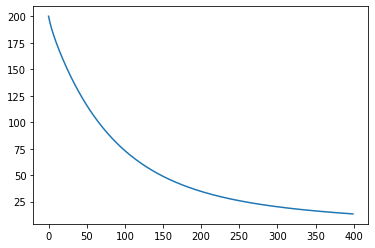

In [24]:
sns.lineplot(x= range(num_iteration),y=cost_func)

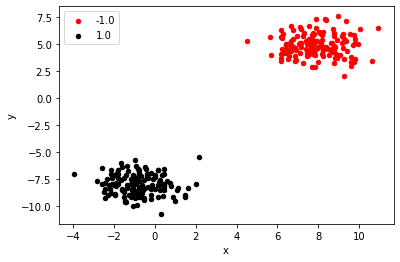

In [26]:
y_unlabel2=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel2))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
#sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()